# Configuración

## Detectando el broker 
Este código sirve para detectar la dirección del broker que está en el laboratorio. Descomente solamente para saber donde está el broker del laboratorio. __Asegúrese de instalar [nmap](https://nmap.org/download.html#windows/ "nmap").__

In [ ]:
# s = !nmap -sn 10.203.162.*  
# macindex = [index for index, string in enumerate(s) if  'MAC Address: B8:27:EB:EB:A9:10' in string]
# b = s[macindex[0]-2]
# broker = b.split()[-1]
# print(f"please connect to broker {broker:s}")

## Instalación de la libreria unmotor
Solo ejecutarla para instalar por primera vez, descomentando las linea siguientes. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__

In [1]:
!pip install -I git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code 

  Cloning https://github.com/nebisman/UNDCMotor.git (to revision main) to /tmp/pip-req-build-mxj_k5u4
  Running command git clone --filter=blob:none --quiet https://github.com/nebisman/UNDCMotor.git /tmp/pip-req-build-mxj_k5u4
  Resolved https://github.com/nebisman/UNDCMotor.git to commit 0171738c37b5fda1d5c78bc816a124a369626065
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached iottalk_paho_mqtt-1.5.1-py3-none-any.whl.metadata (46 kB)
  Using cached control-0.10.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached numpy-2.0.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.1.post1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached ipympl-0.9.4-py3-none-any.whl.metadata (8.7 kB)
  Using cach

## Importación de comandos de la libreria unmotor y de Matplotlib 

A continuación importamos los comandos básicos que usaremos de la libreria unmotor y la libreria Matplotlib para realizar trabajo adicional con las figuras. 

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from unmotor import MotorSystemIoT, get_static_model, get_models_prbs, get_fomodel_step, step_closed

ModuleNotFoundError: No module named 'ipympl'


---

# Modelamiento e identificación del UNDCMotor

A continuación vamos a obtener diferentes modelos del UNDCMotor. 

## Definición del sistema en el IoT

Lo primero que necesitamos es definir el sistema y su conexión al IoT. Esto lo hacemos mediante el  comando

`MotorSystemIoT(plant_number="xxxx", broker_address = "xx.xxx.xxx.xxx")`.

+ El parámetro `plant_number` es el identificador de la planta con que está trabajando. Por ejemplo `plant_number=2020`

+ El parámetro `broker_address` es la dirección IP del broker al cual se conecta la planta. Por ejemplo ` broker_address = "18.204.70.207"` 

In [2]:
my_dcmotor = MotorSystemIoT(plant_number = 2020, broker_address = "18.204.70.207") 

## Modelo estático del UNDCMotor

Es natural comenzar investigando el comportamiento estacionario de un sistema bajo
control. Esto se hace mediante una curva que muestra el valor en estado estacionario de la
salida (en este caso, la velocidad del motor DC) para diferentes valores de la variable de
entrada (en este caso la tensión aplicada). A esta curva se le denomina Modelo Estático del
Sistema.


El modelo estático se puede obtener experimentalmente de varias formas. *Una manera
habitual es ajustar un valor constante de entrada y medir la salida en estado estacionario.
Esto da un punto del modelo estático. Este procedimiento se repite para cubrir el
rango completo de entradas.*

+ La  función `get_static_model(my_dcmotor)` nos permite obtener el modelo estático del UNDCmotor definido por la instancia `my_dcmotor`.
+ Las funciones `plt.savefig(.)` permite guardar la figura en en cualquier formato para su video informe

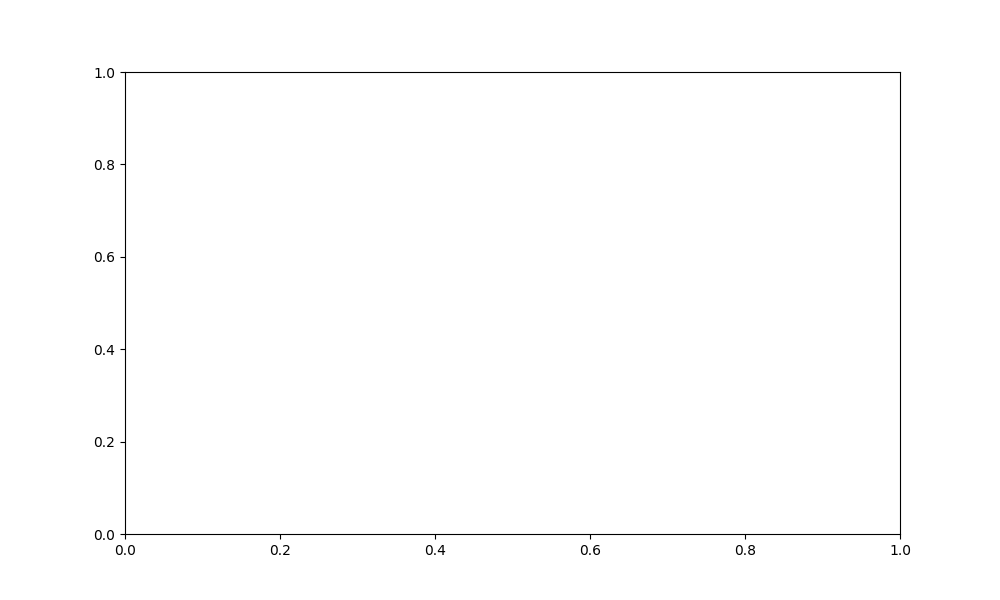

Static model esperiment has been completed


In [5]:
ue, ye = get_static_model(my_dcmotor) 
plt.savefig("static_model.png", format="png", bbox_inches="tight")  

**Note que la salida los valores de estado estacionario de la entrada y la salida quedan registrados en las variables `ue`, `ya`. También quedan guardados en el archivo `\experiment_files\DCmotor_static_gain_response.csv` presente en la carpeta en la que ejecuta este script.**


### Preguntas sobre el modelo estático

Por favor responda las siguientes preguntas sobre el modelo estático en su videoinforme y haga una explicación preliminar muy breve en el documento compartido de la clase de laboratorio

1.  ¿Cuál es la zona muerta del motor?
2.  ¿Para cuales velocidades es muy difícil controlar el motor?
3.  ¿Hasta que velocidad se puede controlar el motor?
4.  Suponga que un modelo aproximado del motor está dado por $G(s)=\frac{\alpha}{\tau\,s+1}$. ¿Cual de los parámetros ($\alpha$ o $\tau$) se ve afectado por la no linealidad de la curva del modelo estático? 

# Modelo dinámico del UNDCMotor

A continuación vamos a obtener el modelo dinámico del UNDCMotor usando dos tipos de experimentos:

1. Modelo por respuesta al escalón
2. Modelo por respuesta a una secuencia binaria pseudoaleatoria.

In [ ]:
motor =  MotorSystemIoT(plant_number="2020", broker_address = "18.204.70.207")
G = get_fomodel_step(motor, yop=-5)